Step 1: Install Dependencies

In [1]:

!pip install -q datasets

Step 2: Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

Step 3: Load the Dataset

In [6]:

from datasets import load_dataset

# Use the full repository ID instead of just "beans"
dataset = load_dataset("AI-Lab-Makerere/beans")

# Verify the structure
print(dataset)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})


Step 4: Preprocess the Data

In [7]:
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(examples):
    # Resize and normalize images
    images = [np.array(img.resize((IMG_SIZE, IMG_SIZE))) / 255.0 for img in examples["image"]]
    examples["pixel_values"] = images
    return examples

# Apply the preprocessing function to the downloaded data
processed_dataset = dataset.map(preprocess, batched=True)

# Helper function to convert to TF Dataset pipeline
def create_tf_dataset(hf_dataset):
    return tf.data.Dataset.from_tensor_slices((
        np.stack(hf_dataset["pixel_values"]),
        np.array(hf_dataset["labels"])
    )).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the final pipelines
train_ds = create_tf_dataset(processed_dataset["train"])
val_ds = create_tf_dataset(processed_dataset["validation"])
test_ds = create_tf_dataset(processed_dataset["test"])

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Step 5: Build the Model

In [8]:
model = keras.Sequential([
    # Input Layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Block 1: Feature Extraction
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2: Feature Extraction (Deeper)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 3: Feature Extraction (Deepest)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Classification Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent the model from memorizing data
    layers.Dense(3, activation='softmax') # Output: 3 probabilities
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Step 6: Train the Model

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35  # Training for 15 iterations over the dataset
)

Epoch 1/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.4337 - loss: 1.1014 - val_accuracy: 0.5865 - val_loss: 0.8633
Epoch 2/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5886 - loss: 0.8876 - val_accuracy: 0.6992 - val_loss: 0.7075
Epoch 3/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6839 - loss: 0.7598 - val_accuracy: 0.7594 - val_loss: 0.6285
Epoch 4/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7441 - loss: 0.6053 - val_accuracy: 0.7594 - val_loss: 0.5439
Epoch 5/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7634 - loss: 0.5657 - val_accuracy: 0.7669 - val_loss: 0.5442
Epoch 6/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7619 - loss: 0.5617 - val_accuracy: 0.7594 - val_loss: 0.6725
Epoch 7/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7335 - loss: 0.5848 - val_accuracy: 0.7293 - val_loss: 0.5184
Epoch 8/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7641 - loss: 0.5181 - val_accuracy: 0.7895 -

Step 7: Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8240 - loss: 0.6742

Final Test Accuracy: 79.69%


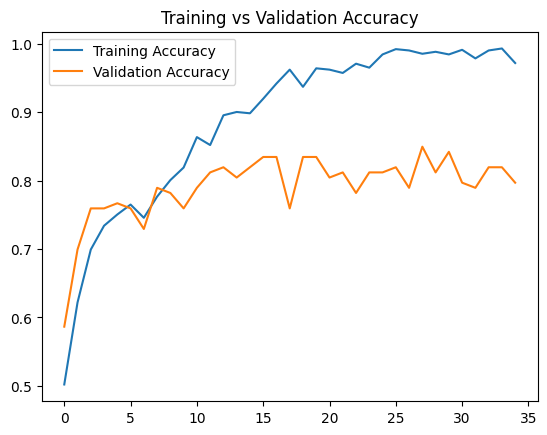

In [10]:
# Check accuracy on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# Visualize Training Progress
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Visualization

Generating Prediction Grid...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


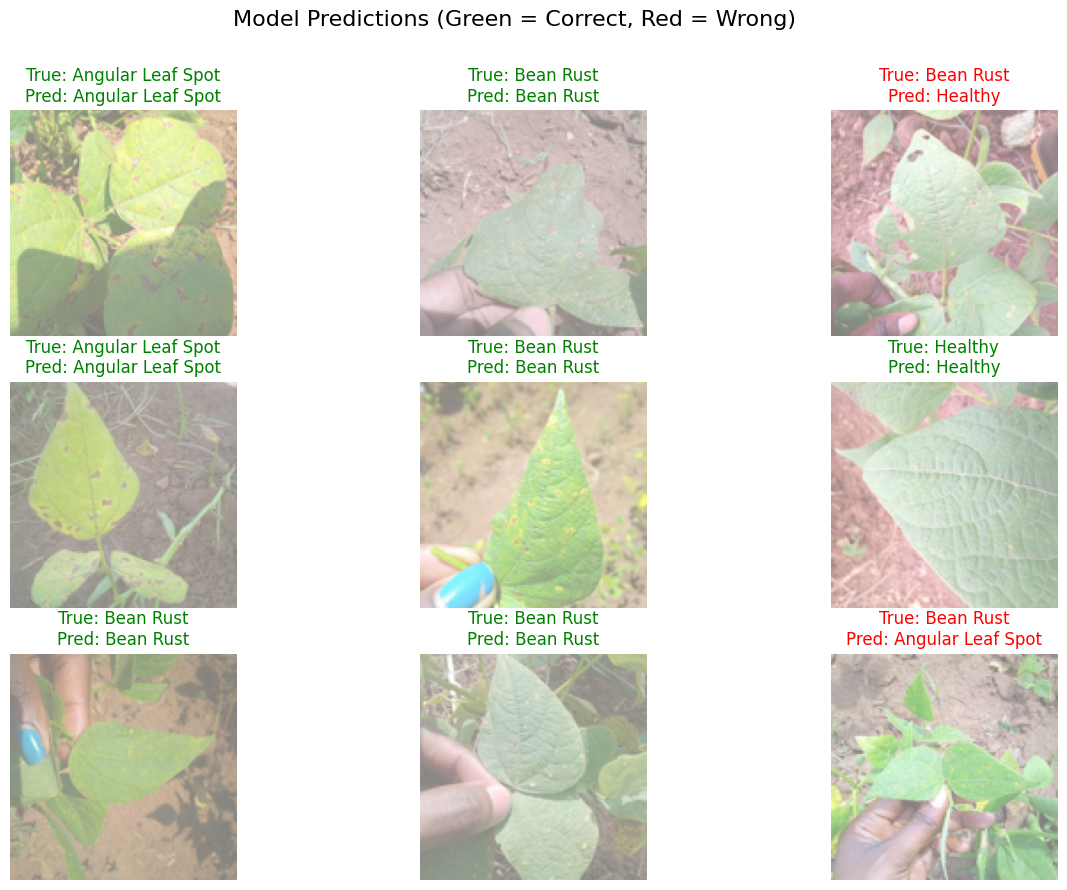

Generating Confusion Matrix...


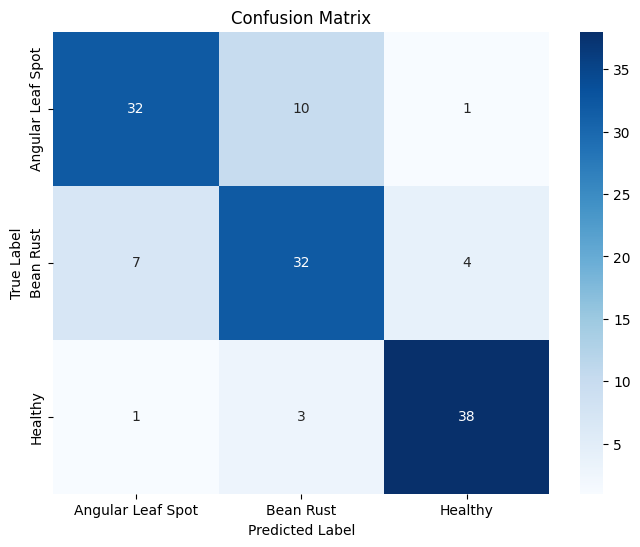

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class names for the Beans dataset
class_names = ['Angular Leaf Spot', 'Bean Rust', 'Healthy']


def plot_predictions(model, dataset):
    plt.figure(figsize=(15, 10))

    # Take one batch of data (32 images)
    images, labels = next(iter(dataset))

    # Get model predictions
    predictions = model.predict(images)
    predicted_ids = np.argmax(predictions, axis=1)

    for i in range(9): # Show top 9 images
        ax = plt.subplot(3, 3, i + 1)

        # Reverse MobileNet preprocessing for display: [-1, 1] -> [0, 1]
        # (If you used the standard model, this might just be direct)
        img_to_show = (images[i] + 1) / 2.0
        plt.imshow(img_to_show)

        # Color code: Green if correct, Red if wrong
        color = 'green' if predicted_ids[i] == labels[i] else 'red'

        title = f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_ids[i]]}"
        plt.title(title, color=color, fontsize=12)
        plt.axis("off")

    plt.suptitle("Model Predictions (Green = Correct, Red = Wrong)", fontsize=16)
    plt.show()

print("Generating Prediction Grid...")
plot_predictions(model, test_ds)


def plot_confusion_matrix(model, dataset):
    # Get all labels and predictions from the test set
    all_labels = []
    all_preds = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        all_labels.extend(labels.numpy())
        all_preds.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(all_labels, all_preds)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

print("Generating Confusion Matrix...")
plot_confusion_matrix(model, test_ds)